In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

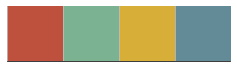

In [244]:
sns.set_style({
    'axes.facecolor': 'white',
    'axes.edgecolor': '.05',
    'axes.grid': True,
    'axes.axisbelow': True,
    'axes.labelcolor': '.0',
    'figure.facecolor': 'white',
    'grid.color': '.75',
    'grid.linestyle': '-',
    'text.color': '.15',
    'xtick.color': '.05',
    'ytick.color': '.05',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'patch.edgecolor': 'w',
    'patch.force_edgecolor': True,
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial', 'Helvetica Neue', 'sans-serif'],
    'xtick.bottom': False,
    'xtick.top': False,
    'ytick.left': False,
    'ytick.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'axes.spines.top': False
})

colors = [
  "#be503e",
  "#7bb292",
  "#d7ae38",
  "#628b97"
]
custom_pal = sns.color_palette(colors)
sns.palplot(custom_pal)

# Submitted Runs Evaluation

In [4]:
df = (
    pd.read_json('../../../tmp/data-26-10-2020/rankings/original-runs-evaluation.jsonl', lines=True)
    .rename({
        "corpus": "Collection",
        "tag": "Run",
        "topics": "Topics",
        "pseudoNDCG": "Pseudo nDCG"
    }, axis=1)
    .replace({
        # Collection names
        "cw09": "CW09",
        "cw12": "CW12",
        "cw12wb12": "CW12+",
        "cc15": "CC15",
    })
)

#### plot-web-2009-reproducibility-with-bpref from the paper

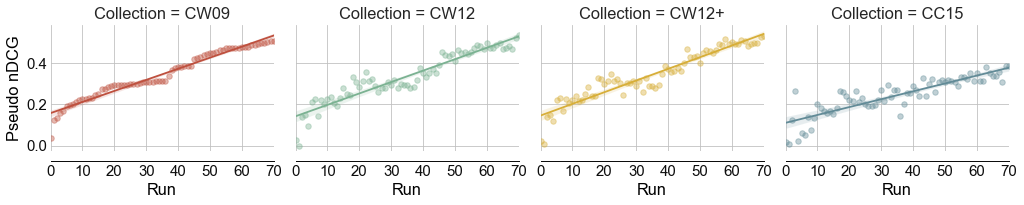

In [242]:
def plot_correlations_per_corpus(df, measure: str, topics):
    df = df[df['Topics'] == topics]
    sorted_approaches = {k: v for v,k in enumerate(df[(df['Collection'] == 'CW09')].sort_values(measure).Run.unique())}
    df = df.loc[:,["Collection","Run",measure]].sort_values(measure).replace(sorted_approaches)
    
    g = sns.FacetGrid(
        df, 
        col="Collection",
        hue="Collection",
        col_order=['CW09', 'CW12', 'CW12+', 'CC15'],
        hue_order=['CW09', 'CW12', 'CW12+', 'CC15'],
        height=3,
        aspect=1.2,
        palette=sns.color_palette(colors)
    )
    g.map(sns.regplot, "Run", measure, marker=".",scatter_kws={"alpha":0.4,"s":120})
    #g.add_legend()
    #sns.despine(left=True)
    return g

with sns.plotting_context("paper", font_scale=1.7):
    g = plot_correlations_per_corpus(df, 'Pseudo nDCG', '1-50')
    sns.despine(offset=10, left=True)
g.savefig('plot-web-2009-reproducibility-with-bpref.pdf', format='pdf')

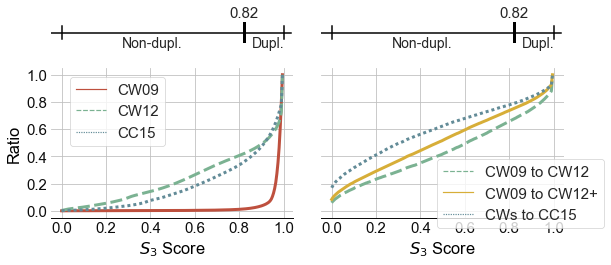

In [251]:
infiles = {
    "../resources/canonical-edges-s3-aggregations-cc-2015-11.json": "CC15",
    "../resources/canonical-edges-s3-aggregations-cw09.json": "CW09",
    "../resources/canonical-edges-s3-aggregations-cw12.json": "CW12"
}

infiles_transferred = {
    "../resources/s3-aggregations-cw09-to-cw12.json": "CW09 to CW12",
    "../resources/s3-aggregations-cw09-to-cw12-and-wayback.json": "CW09 to CW12+",
    "../resources/s3-aggregations-cw-to-cc15.json": "CWs to CC15",
}

def load_files(infiles):
    df = []
    for path, corpus in infiles.items():
        with open(path, 'r') as file:
            data = (
                pd.DataFrame(pd.Series(json.load(file)))
                .reset_index()
                .rename({'index': 'S3 Score', 0: 'Number'}, axis=1)
            )
            data['Corpus'] = corpus
            df.append(data)
    df = pd.concat(df)
    df['S3 Score'] = df['S3 Score'].astype(float)
    df['Number'] = df['Number'].astype(float)
    df = df.sort_values(['Corpus', 'S3 Score'])

    df = (
        df
        .merge(
            df
            .groupby('Corpus')
            .sum()
            .rename({'Number': 'Sum'}, axis=1)
            .drop('S3 Score', axis=1),
            on='Corpus',
            how='left'
        )
    )

    df['Cumulative'] = df.loc[:, ['Number', 'Corpus']].groupby('Corpus').cumsum()
    df['Ratio'] = df['Cumulative'] / df['Sum']
    df = df.rename({'S3 Score': '$S_{3}$ Score'}, axis=1)
    
    return df

with sns.plotting_context("paper", font_scale=1.7):
    fig, ax = plt.subplots(
        2,
        2, 
        figsize=(9, 4), 
        sharex=True, 
        sharey='row', 
        gridspec_kw=dict(width_ratios=[1,1], height_ratios=[1,7])
    )

    g = sns.lineplot(
        data=load_files(infiles), 
        x='$S_{3}$ Score', 
        y='Ratio', 
        style="Corpus", 
        hue="Corpus",
        palette = sns.color_palette([colors[0],colors[1],colors[3]]),
        style_order=["CW09", "CW12", "CC15"],
        hue_order=["CW09", "CW12", "CC15"],
        ax=ax[1][0],
        linewidth = 3 
    )
    g.legend(bbox_to_anchor=(0.473, .94), borderaxespad=0.)

    g = sns.lineplot(
        data=load_files(infiles_transferred), 
        x='$S_{3}$ Score', 
        y='Ratio', 
        style="Corpus", 
        hue="Corpus",
        palette = sns.color_palette(colors[1:4]),
        style_order=["CW09 to CW12+", "CW09 to CW12", "CWs to CC15"],
        hue_order=["CW09 to CW12", "CW09 to CW12+", "CWs to CC15"],
        ax=ax[1][1],
        linewidth = 3 
    )
    g.legend(bbox_to_anchor=(0.48, .39), borderaxespad=0.)

    def plot_indicator(ax):
        plt.sca(ax)
        plt.axhline(y=.5, xmin=0, xmax=0.99, linewidth=1.5, color='k')
        plt.axvline(x=.82, ymin=0, ymax=1, linewidth=3, color='k')
        plt.axvline(x=0, ymin=.2, ymax=.8, linewidth=1.5, color='k')
        plt.axvline(x=1, ymin=.2, ymax=.8, linewidth=1.5, color='k')
        plt.text(0.41, 0, 'Non-dupl.', horizontalalignment='center', verticalalignment='center', fontsize=14)
        plt.text(0.93, 0, 'Dupl.', horizontalalignment='center', verticalalignment='center', fontsize=14)
        plt.text(0.82, 1.4, '0.82', horizontalalignment='center', verticalalignment='center', fontsize=15)
        plt.axis('off')

    plot_indicator(ax[0][0])
    plot_indicator(ax[0][1])

    sns.despine(left=True)
    plt.tight_layout()
    g.get_figure().savefig('canonical-edges.pdf')


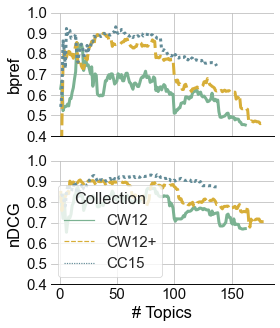

In [270]:
with sns.plotting_context("paper", font_scale=1.7):
    fig, ax = plt.subplots(
        2,
        1, 
        figsize=(4,5), 
        sharex=True, 
        sharey=True,
        gridspec_kw=dict(width_ratios=[1], height_ratios=[1,1])
    )
    sns.lineplot(
        data=(
            pd.read_json("../resources/bpref-correlations.jsonl")
            .reset_index()
            .melt(id_vars="index")
            .replace({
                "bpref-to-cw12": "CW12",
                "bpref-to-cw12wb12": "CW12+",
                "bpref-to-cc15": "CC15"
            })
            .rename({
                "index": "Topic",
                "variable": "Collection",
                "value": "bpref"
            }, axis=1)
        ), 
        x='Topic', 
        y='bpref', 
        hue='Collection',
        style="Collection",
        style_order=["CW12", "CW12+", "CC15"],
        hue_order=["CW12", "CW12+", "CC15"],
        palette = sns.color_palette(colors[1:4]),
        lw=3,
        legend=None,
        ax=ax[0]
    )
    sns.lineplot(
        data=(
            pd.read_json("../resources/ndcg-correlations.jsonl")
            .reset_index()
            .melt(id_vars="index")
            .replace({
                "pseudoNDCG-to-cw12": "CW12",
                "pseudoNDCG-to-cw12wb12": "CW12+",
                "pseudoNDCG-to-cc15": "CC15"
            })
            .rename({
                "index": "# Topics",
                "variable": "Collection",
                "value": "nDCG"
            }, axis=1)
        ), 
        x="# Topics", 
        y='nDCG', 
        hue='Collection', 
        style="Collection",
        style_order=["CW12", "CW12+", "CC15"],
        hue_order=["CW12", "CW12+", "CC15"],
        palette = sns.color_palette(colors[1:4]),
        lw=3,
        #legend=None,
        ax=ax[1]
    )
    plt.ylim((0.4, 1))
    #sns.despine(offset=0, left=True)
    fig.savefig('plot-case-study-selection.pdf', format='pdf')

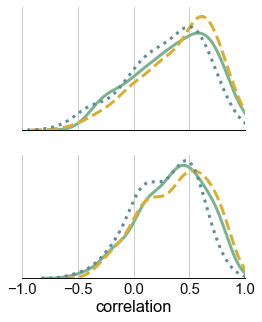

In [269]:
with sns.plotting_context("paper", font_scale=1.7):
    fig, ax = plt.subplots(
        2,
        1, 
        figsize=(4,5), 
        sharex=True, 
        sharey=True,
        gridspec_kw=dict(width_ratios=[1], height_ratios=[1,1])
    )
    
    df1 = pd.read_json("../resources/topic-level-correlation-bpref.json")
    df2 = pd.read_json("../resources/topic-level-correlation-ndcg.json")
    
    sns.kdeplot(
        x = df1.loc[df1.corpus=="cw12","correlation"], 
        color=colors[1],
        lw=3,
        ax=ax[0]
    )
    sns.kdeplot(
        x = df1.loc[df1.corpus=="cw12wb12","correlation"], 
        color=colors[2],
        linestyle="--",
        lw=3,
        ax=ax[0]
    )
    sns.kdeplot(
        x = df1.loc[df1.corpus=="cc15","correlation"], 
        color=colors[3],
        linestyle=":",
        lw=3,
        ax=ax[0]
    )
    sns.kdeplot(
        x = df2.loc[df2.corpus=="cw12","correlation"], 
        color=colors[1],
        lw=3,
        ax=ax[1]
    )
    sns.kdeplot(
        x = df2.loc[df2.corpus=="cw12wb12","correlation"], 
        color=colors[2],
        lw=3,
        linestyle="--",
        ax=ax[1]
    )
    sns.kdeplot(
        x = df2.loc[df2.corpus=="cc15","correlation"], 
        color=colors[3],
        lw=3,
        linestyle=":",
        ax=ax[1]
    )
    ax[0].axes.get_yaxis().set_visible(False)
    ax[1].axes.get_yaxis().set_visible(False)
    plt.xlim((-1,1))
    #sns.despine(offset=0, left=True)
    # Needs manual cleanup in illustrator
    fig.savefig('plot-case-study-distribution.pdf', format='pdf')